In [45]:
# ORIGINAL RGB FILE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pystan

from IPython.display import display

from matplotlib import rc
rc("font", family="serif", size=11)

In [46]:
output = pd.read_csv('../data/output_1000stars.csv', usecols=range(1,4))
#IDs = [(output.loc[output['ID'] == random.choice(output['ID'])]).iloc[0]['Numax'] for i in range(5)]

noStars = 50
# Select a random sample of stars from the file, recording their IDs
IDs = [random.choice(output['ID']) for i in range(noStars)]
# Create a list of the numax values corresponding to each ID
Numax = [(output.loc[(output['ID'] == IDs[i])]).iloc[0]['Numax'] for i in range(len(IDs))]
Numax_err = [(output.loc[(output['ID'] == IDs[i])]).iloc[0]['Numax_err'] for i in range(len(IDs))]

print(IDs)
print(Numax)

[3760337, 10857953, 9760904, 9002344, 6428974, 10282002, 10198347, 9635603, 9581445, 8016118, 5167473, 9450786, 9353531, 11020211, 11954465, 9662343, 9581445, 11199783, 11199105, 10684837, 2554924, 10991271, 3222670, 7672405, 7744204, 7100768, 11083319, 9706209, 7345200, 4271039, 5517442, 10718491, 9843358, 8611114, 8962844, 10212620, 5339823, 11394905, 12167521, 3934458, 3747860, 3528656, 5168382, 10857953, 6101471, 10358632, 8285510, 10524715, 3529276, 7351098]
[36.21493825782535, 32.053664979812744, 29.355705432453018, 42.48256034225872, 41.66139350659274, 29.422233238239457, 37.20488261674781, 31.1594239665535, 59.88654450458836, 83.04250767229301, 30.892351398460985, 27.0616719896331, 28.85533843034707, 105.47796721770443, 103.16331379664507, 42.96937198336262, 59.88654450458836, 44.53273832001733, 30.25439407753104, 86.36293877530365, 33.57638589708347, 77.4896676489379, 33.93456376542629, 13.457175230713416, 52.241476783086966, 24.84315293998052, 44.01508383518345, 29.8464369133

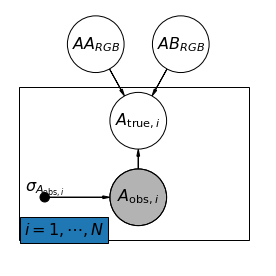

In [47]:
from matplotlib import rc
rc("font", family="serif", size=16)
import daft
pgm = daft.PGM([3,3], grid_unit=3, node_unit=2)
# Hierarchical parameters.
pgm.add_node(daft.Node("AA", r"$AA_{RGB}$", 1.0, 2.6))
pgm.add_node(daft.Node("AB", r"$AB_{RGB}$", 2.0, 2.6))
# Add latent variables 
pgm.add_node(daft.Node("A_true", r"$A_{{\rm true},i}$", 1.5, 1.7))
# Data.
pgm.add_node(daft.Node("A_obs", r"$A_{{\rm obs},i}$", 1.5, 0.8, observed=True))
pgm.add_node(daft.Node("Aerr", r"$\sigma_{A_{{\rm obs},i}}$", 0.4, 0.8, fixed=True, offset=[0.0,0.4]))
# Add in the edges.
pgm.add_edge("AA", "A_true")
pgm.add_edge("AB", "A_true")
pgm.add_edge("A_obs", "A_true")
pgm.add_edge("Aerr", "A_obs")
# And a plate.
pgm.add_plate(daft.Plate([0.1, 0.4, 2.7, 1.7], label=r"$i = 1, \cdots, N$",
    shift=-0.1))
# Render and save.
pgm.render()

In [48]:
modesID = [pd.read_csv('../data/rgbmodes/modes_'+str(IDs[i])+'.csv', usecols=['f0', 'f0_err', 'A0'])
           for i in np.arange(0,len(IDs),1)]
lenmodes = [len(modesID[i]) for i in range(len(IDs))]
maxmodes = max(lenmodes)
arr_n = np.zeros([len(IDs),maxmodes])
arr_freq = np.zeros([len(IDs),maxmodes])
arr_freqerr = np.zeros([len(IDs),maxmodes])


dnu_avgID = []
for i in np.arange(0,len(IDs),1):
    modesID[i] = modesID[i].sort_values(by=['f0'])
    modesID[i] = modesID[i].set_index(np.arange(0,len(modesID[i]),1))
    modesID[i]['dnu'] = (modesID[i]['f0'].diff(2).shift(-1))/2
    dnu_avg = (np.mean(modesID[i]['dnu']))
    dnu_avgID.append(dnu_avg)
    
    n_min = int(modesID[i]['f0'].min() / dnu_avg)
    n = np.arange(n_min, n_min+len(modesID[i]), 1)
    modesID[i].insert(loc=0, column='n', value=n)
    
    # Loop to ensure all arrays are the same length
    if lenmodes[i] < maxmodes:
        l = lenmodes[i]
        while l < maxmodes:
            newrow = {'n': int(np.max(modesID[i]['n'])+1),
                      'f0': np.max(modesID[i]['f0'])+dnu_avgID[i],
                      'f0_err': 100000}
            modesID[i] = modesID[i].append(newrow, ignore_index=True)
            #modesID[i].loc[l] = [l, int(np.max(modesID[i]['n']+l)), (np.max(modesID[i]['dnu'])+dnu_avgID[i]), np.nan , 10000]
            #app = pd.DataFrame([(np.max(modesID[i]['dnu'])+dnu_avgID[i]), 10000], columns=['n', 'f0', 'f0_err'])
            #modesID[i].append(app, ignore_index=True)
            l += 1
        
    arr_n[i,:] = modesID[i]['n']
    arr_freq[i,:] = modesID[i]['f0']
    arr_freqerr[i,:] = modesID[i]['f0_err']
    
    #display(modesID[i])
dnu_avgarr = np.asarray(dnu_avgID)

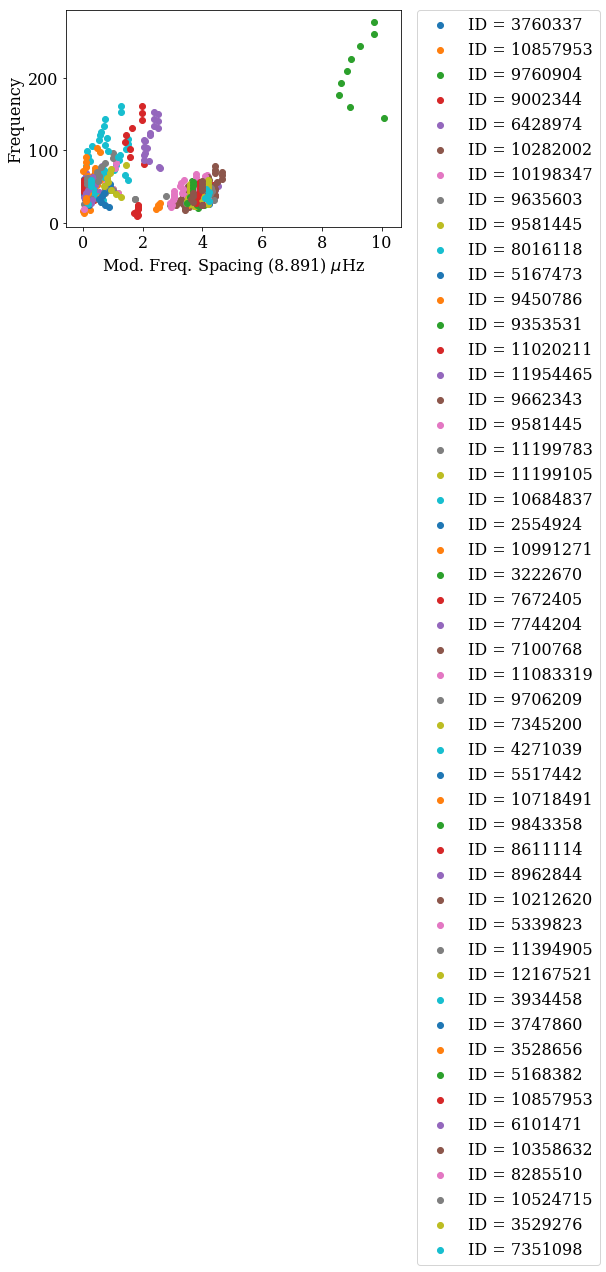

In [49]:
for i in np.arange(0,len(IDs),1):
    plt.scatter(modesID[i]['f0'] % dnu_avgID[i], modesID[i]['f0'], label=r'ID = '+str(IDs[i]))

#Define start parameters
eps = []
for i in range(len(IDs)):
    epsilon1 = np.median((modesID[i].f0 % dnu_avg) / dnu_avg)
    eps.append(epsilon1)
epsilon = np.asarray(eps)

numax_obs = Numax
nmax = numax_obs/dnu_avgarr - epsilon
alpha = 0.015*dnu_avgarr**(-0.32)
A = 0.06*dnu_avgarr**(-0.88) 
G = np.ones([len(IDs)])*3.08
tau = np.ones([len(IDs)])*10
phi = np.ones([len(IDs)])*1.71

plt.ylabel('Frequency')
plt.xlabel(r'Mod. Freq. Spacing ('+ str(u"%.3f" % dnu_avg) +') $\mu$Hz')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [65]:
code = '''
data {
    int N;  //number of stars
    int M; //number of modes
    real n[N, M];
    real freq[N, M];
    real freq_err[N, M];
    real dnu_guess[N];
}
parameters {
    real dnu[N];
    real nmax[N];
    real epsilon[N];
    real alpha[N];
    real<lower = 0> A[N];
    real<lower = 0> G[N];
    real<lower = -2.0*pi(), upper = 2.0*pi()> phi[N];
    real<lower = 0> tau[N];
    real epsA;
    real epsB;
    real alA;
    real alB;
    real AA;
    real AB;
    
}
model {
    real mod[M];
    for (i in 1:N){
        for (j in 1:M){
            mod[j] = (n[i,j] + epsilon[i] + (alpha[i]/2) * (nmax[i] - n[i,j])^2 + 
                A[i]*G[i]/(2*pi()) * sin((2*pi()*(n[i,j]-nmax[i]))/G[i] + phi[i]))*dnu[i]*exp(-n[i,j]/tau[i]);
            mod[j] ~ normal(freq[i], freq_err[i]);
        }
        dnu[i] ~ normal(dnu_guess[i], dnu_guess[i]*0.001);
        epsilon[i] ~ normal(epsA + epsB*log(dnu[i]), 0.5);
        alpha[i] ~ lognormal(log(alA*dnu[i]^(-alB)), 0.3);
        A[i] ~ lognormal(log(AA*dnu[i]^(-AB)), 0.4);
        //epsilon[i] ~ uniform(-1.0, 2.0);
        //alpha[i] ~ lognormal(log(0.015*dnu[i]^(-0.32)), 0.5);
        //A[i] ~ lognormal(log(0.06*dnu[i]^(-0.88)), 0.6);
    }
    nmax ~ normal(10, 4);
    G ~ normal(3.08, 0.65);
    tau ~ normal(50, 15);
    epsA ~ normal(0.57, 0.008);
    epsB ~ normal(0.59, 0.008);
    alA ~ normal(0.019, 0.0005);
    alB ~ normal(0.29, 0.008);
    AA ~ normal(0.065, 0.005);
    AB ~ normal(0.87, 0.05);
}
'''
sm = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_394a6295be07955ff6ffcf35595ab801 NOW.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/2_/b8v0t8pn1hj1p3r4lyfvvv2h0000gn/T/tmpc6an1iyt/stanfit4anon_model_394a6295be07955ff6ffcf35595ab801_6762228628400649038.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [66]:
fits = []

stan_data = {'N': len(IDs),
         'M': maxmodes,
         'n': arr_n, 
         'freq': arr_freq,
         'freq_err': arr_freqerr,
         'dnu_guess': dnu_avgarr
        }
start = {'dnu': dnu_avgarr,
         'nmax': nmax,
         'epsilon': epsilon,
         'alpha': alpha,
         'A': A,
         'G': G,
         'tau': tau,
         'phi': phi,
         'epsA': 0.601,
         'epsB': 0.632,
         'alA': 0.015,
         'alB': 0.32,
         'AA': 0.06,
         'AB': 0.88
    }
nchains = 4

fit = sm.sampling(data=stan_data, iter=10000, chains=nchains, init=[start for n in range(nchains)])

In [67]:
print(fit)

Inference for Stan model: anon_model_394a6295be07955ff6ffcf35595ab801.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu[1]        4.47  2.4e-3 4.4e-3   4.46   4.46   4.47   4.47   4.48      3    3.8
dnu[2]        4.18  4.4e-3 6.3e-3   4.17   4.18   4.18   4.19   4.19      2  13.43
dnu[3]        4.17  2.5e-3 3.6e-3   4.16   4.16   4.17   4.17   4.17      2  43.85
dnu[4]        4.68  4.2e-3   0.01   4.66   4.67   4.68   4.69   4.71      8   2.53
dnu[5]        4.69  3.6e-3 5.2e-3   4.69   4.69   4.69    4.7    4.7      2  39.88
dnu[6]        3.78  4.6e-3 6.6e-3   3.77   3.77   3.78   3.79   3.79      2  44.21
dnu[7]        4.48  2.0e-3 2.8e-3   4.48   4.48   4.48   4.48   4.48      2  41.95
dnu[8]         3.4    0.02   0.03   3.36   3.37    3.4   3.42   3.47      3   4.02
dnu[9]        9.01    0.75   1.75   6.53   7.38   8.94  10.52 

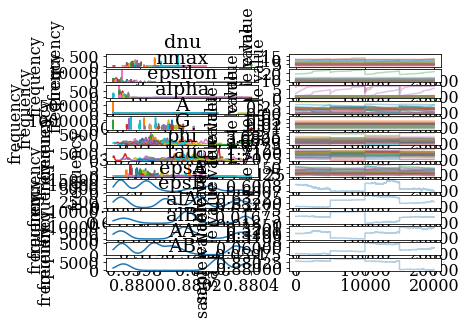

In [68]:
fit.plot()
plt.show()

In [69]:
def model(n, dnu, nmax, epsilon, alpha, A, G, phi, tau):
    freqs = (n + epsilon + (alpha/2) * (n - nmax)**2 + ((A*G)/(2*np.pi)) * np.sin((2*np.pi*(n-nmax))/G + phi)) * dnu * np.exp(-n/tau)
    return freqs

#modesID[0]['n']
g2 = model(modesID[0]['n'], fit['dnu'][0].mean(), fit['nmax'][0].mean(), fit['epsilon'][0].mean(), fit['alpha'][0].mean(),
          fit['A'][0].mean(), fit['G'][0].mean(), fit['phi'][0].mean(), fit['tau'][0].mean())


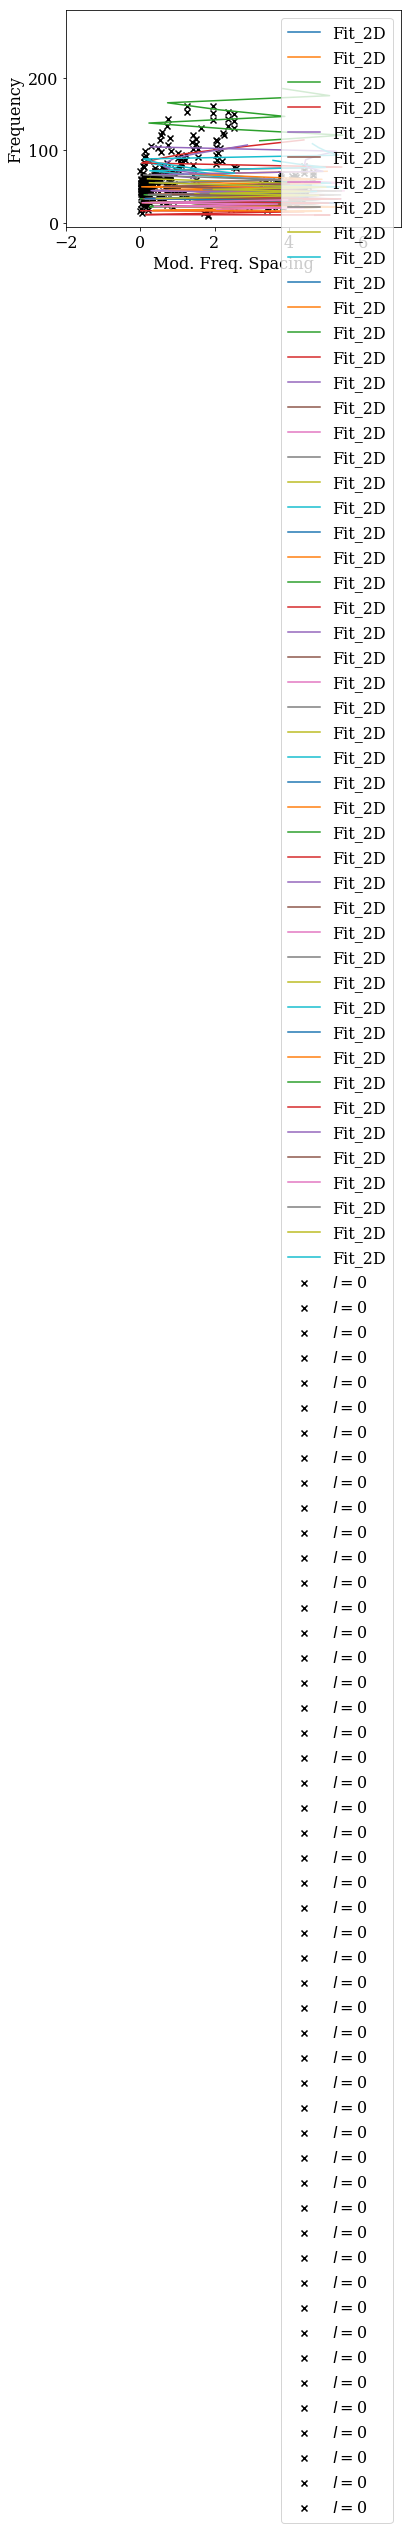

In [70]:
for i in range(len(IDs)):
    plt.figure(len(IDs))
    plt.scatter(modesID[i]['f0'] % np.mean(modesID[i]['dnu']), modesID[i]['f0'], c='k', marker='x', label=r'$l=$'+str(0))
    #plt.errorbar(modesID[i]['f0'] % np.mean(modesID[i]['dnu']), modesID[i]['f0'], xerr=modesID[i]['f0_err'], zorder=0, fmt="none", label="none",
             #c='k', capsize=2, markersize=4, elinewidth=1)
    g2 = model(modesID[i]['n'], np.mean(modesID[i]['dnu']), fit['nmax'][i].mean(), fit['epsilon'][i].mean(), fit['alpha'][i].mean(),
          fit['A'][i].mean(), np.median(fit['G'][i]), fit['phi'][i].mean(), fit['tau'][i].mean())
    plt.plot(g2 % fit['dnu'][0].mean(), g2, label='Fit_2D')

plt.ylabel('Frequency')
plt.xlabel(f'Mod. Freq. Spacing')
plt.xlim(-2,7)
plt.legend()
plt.show()

Text(0.5, 0.98, 'Parameters plotted against $\\langle \\Delta \\nu \\rangle$')

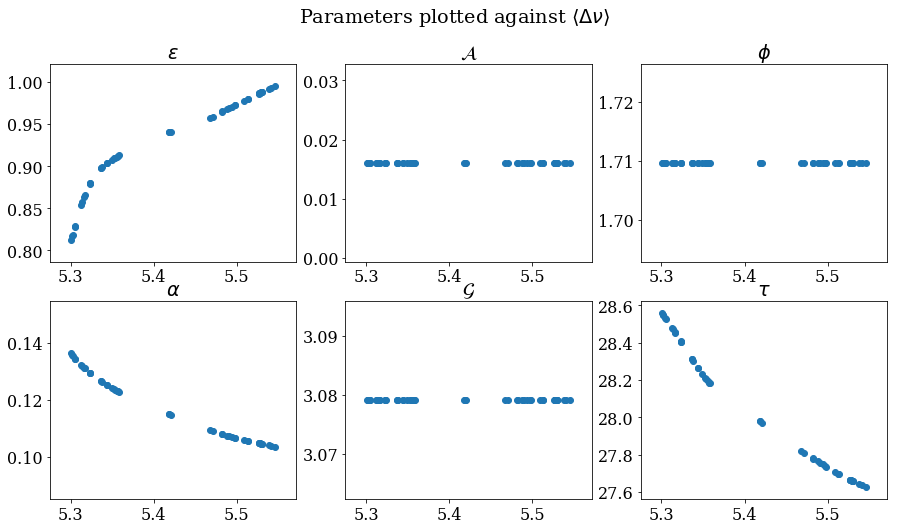

In [71]:
dnus = []
eps = []
alphas = []
As = []
Gs = []
phis = []
taus = []
for i in range(len(IDs)):
    dnus.append(fit['dnu'][i].mean())
    eps.append(fit['epsilon'][i].mean())
    alphas.append(fit['alpha'][i].mean())
    As.append(fit['A'][i].mean())
    Gs.append(fit['G'][i].mean())
    phis.append(fit['phi'][i].mean())
    taus.append(fit['tau'][i].mean())
    
fig, axs = plt.subplots(2, 3, figsize=(15, 8), sharey=False, sharex=False)
axs[0,0].scatter(dnus, eps)
axs[0,0].set_title(r'$\epsilon$')
axs[1,0].scatter(dnus, alphas)
axs[1,0].set_title(r'$\alpha$')
axs[0,1].scatter(dnus, As)
axs[0,1].set_title(r'$\mathcal{A}$')
axs[1,1].scatter(dnus, Gs)
axs[1,1].set_title(r'$\mathcal{G}$')
axs[0,2].scatter(dnus, phis)
axs[0,2].set_title(r'$\phi$')
axs[1,2].scatter(dnus, taus)
axs[1,2].set_title(r'$\tau$')
fig.suptitle(r'Parameters plotted against $\langle \Delta \nu \rangle$')

In [64]:
import corner
data = np.vstack([fit['epsilon'], fit['alpha'], fit['dnu'], fit['nmax'],
                  fit['a'], fit['omega'], fit['phi'], fit['tau']]).T
corner.corner(data, labels=[r'$\epsilon$', r'$k$',r'$\Delta\nu$',r'$n_{max}$',
                            r'$A$', r'$\omega$', r'$\phi$', r'$\tau$'])
              #, truths=[1.436, 0.07, 0.3, 2, 0])
plt.show()

ValueError: No parameter a